# 1. 3D Tensor dataset

In this notebook, we create a custom dataset class named Random3DTensorDataset that extends PyTorch's Dataset. This dataset generates random 3D tensors and corresponding random binary labels.

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader

class Random3DTensorDataset(Dataset):
    def __init__(self, num_samples: int, tensor_shape: tuple = (3, 32, 32)):
        self.num_samples = num_samples
        self.tensor_shape = tensor_shape

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        tensor = torch.rand(*self.tensor_shape)
        label = torch.randint(0, 2, ())
        return tensor, label

# Create dataset and DataLoader
dataset = Random3DTensorDataset(num_samples=100, tensor_shape=(3, 32, 32))
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

# Fetch one batch
for batch_tensors, batch_labels in dataloader:
    print("Tensor batch shape:", batch_tensors.shape)
    print("Labels:", batch_labels)
    break

Tensor batch shape: torch.Size([10, 3, 32, 32])
Labels: tensor([0, 1, 0, 0, 1, 0, 1, 1, 1, 1])


# 2. Datastreamers

In [2]:
import torch
import random

class BaseDatastreamer:
    def __init__(self, dataset, batchsize, preprocessor=None, max_batches=None):
        self.dataset = dataset
        self.batchsize = batchsize
        self.preprocessor = preprocessor
        self.max_batches = max_batches

    def stream(self):
        batch_count = 0
        while True:
            if self.max_batches and batch_count >= self.max_batches:
                break

            indices = list(range(len(self.dataset)))
            random.shuffle(indices)
            for i in range(0, len(indices), self.batchsize):
                batch_indices = indices[i: i + self.batchsize]
                batch = [self.dataset[idx] for idx in batch_indices]
                
                batch_tensors, batch_labels = zip(*batch)  
                
                batch_tensors = torch.stack(batch_tensors)  
                batch_labels = torch.tensor(batch_labels)
                
                if self.preprocessor:
                    batch_tensors = self.preprocessor(batch_tensors)

                yield batch_tensors, batch_labels
                batch_count += 1


def batch_processor(batch_tensors):
    return batch_tensors * 2

# Create dataset
dataset = Random3DTensorDataset(num_samples=100, tensor_shape=(3, 32, 32))

# Create a datastreamer with a limit of 5 batches
streamer = BaseDatastreamer(dataset=dataset, batchsize=10, preprocessor=batch_processor, max_batches=5)

data_gen = streamer.stream()

for _ in range(5):
    batch_tensors, batch_labels = next(data_gen)
    print(batch_tensors.shape)
    print(batch_labels)
    print("\n")



torch.Size([10, 3, 32, 32])
tensor([1, 1, 1, 1, 0, 0, 0, 0, 1, 1])


torch.Size([10, 3, 32, 32])
tensor([1, 1, 0, 0, 1, 1, 1, 0, 0, 1])


torch.Size([10, 3, 32, 32])
tensor([1, 0, 1, 0, 0, 1, 0, 0, 1, 1])


torch.Size([10, 3, 32, 32])
tensor([1, 0, 0, 0, 0, 0, 1, 1, 0, 0])


torch.Size([10, 3, 32, 32])
tensor([1, 0, 0, 0, 0, 1, 1, 0, 0, 0])




# 3. Tune the network

In [3]:
from mads_datasets import DatasetFactoryProvider, DatasetType

from mltrainer.preprocessors import BasePreprocessor
from mltrainer import imagemodels, Trainer, TrainerSettings, ReportTypes, metrics

import torch.optim as optim
import gin

In [4]:
gin.parse_config_file("model.gin")

ParsedConfigFileIncludesAndImports(filename='model.gin', imports=['gin.torch.external_configurables'], includes=[])

In [5]:
preprocessor = BasePreprocessor()
fashionfactory = DatasetFactoryProvider.create_factory(DatasetType.FASHION)
streamers = fashionfactory.create_datastreamer(batchsize=64, preprocessor=preprocessor)
train = streamers["train"]
valid = streamers["valid"]
trainstreamer = train.stream()
validstreamer = valid.stream()

2025-02-17 11:54:53.308 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 11:54:53.319 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt


In [6]:
print(gin.config_str())

import gin.torch.external_configurables

# Parameters for NeuralNetwork:
# ==============================================================================
NeuralNetwork.num_classes = 10
NeuralNetwork.units1 = 512
NeuralNetwork.units2 = 512



In [7]:
accuracy = metrics.Accuracy()

In [8]:
import torch
gin.parse_config_file("model.gin")

units = [256, 128, 64]
loss_fn = torch.nn.CrossEntropyLoss()

settings = TrainerSettings(
    epochs=5,
    metrics=[accuracy],
    logdir="models",
    train_steps=len(train),
    valid_steps=len(valid),
    reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.GIN],
)

for unit1 in units:
    for unit2 in units:
        gin.bind_parameter("NeuralNetwork.units1", unit1)
        gin.bind_parameter("NeuralNetwork.units2", unit2)

        model = imagemodels.NeuralNetwork()
        trainer = Trainer(
            model=model,
            settings=settings,
            loss_fn=loss_fn,
            optimizer=optim.Adam,
            traindataloader=trainstreamer,
            validdataloader=validstreamer,
            scheduler=optim.lr_scheduler.ReduceLROnPlateau
        )
        trainer.loop()


2025-02-17 11:54:53.624 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to models/20250217-115453
2025-02-17 11:54:53.629 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.


100%|██████████| 937/937 [00:14<00:00, 62.93it/s]
2025-02-17 11:55:09.332 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.5106 test 0.4156 metric ['0.8519']
100%|██████████| 937/937 [00:10<00:00, 90.29it/s]
2025-02-17 11:55:20.438 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.3649 test 0.3813 metric ['0.8621']
100%|██████████| 937/937 [00:11<00:00, 84.28it/s]
2025-02-17 11:55:32.342 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.3278 test 0.4000 metric ['0.8539']
2025-02-17 11:55:32.343 | INFO     | mltrainer.trainer:__call__:234 - best loss: 0.3813, current loss 0.4000.Counter 1/10.
100%|██████████| 937/937 [00:14<00:00, 64.52it/s]
2025-02-17 11:55:47.773 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.3048 test 0.3413 metric ['0.8780']
100%|██████████| 937/937 [00:16<00:00, 55.27it/s]
2025-02-17 11:56:05.794 | INFO     | mltrainer.trainer:report:191 - Epoch 4 train 0.2862 test 0.3582 metric ['0.8685']
2025-02-17 11:56:05.795 | INFO  

# Updated Experiment Code with HeatMap

2025-02-17 12:08:09.657 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 12:08:09.659 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt
2025-02-17 12:08:09.857 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to models/20250217-120809
2025-02-17 12:08:09.862 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.


Training with units: 16, batch size: 4


100%|██████████| 100/100 [00:00<00:00, 357.56it/s]
2025-02-17 12:08:10.215 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 2.1309 test 1.9361 metric ['0.3300']
100%|██████████| 100/100 [00:00<00:00, 223.30it/s]
2025-02-17 12:08:10.716 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 1.7635 test 1.5294 metric ['0.4750']
100%|██████████| 100/100 [00:00<00:00, 382.39it/s]
2025-02-17 12:08:11.023 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 1.2545 test 1.0852 metric ['0.6050']
100%|██████████| 3/3 [00:01<00:00,  2.59it/s]
2025-02-17 12:08:11.033 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 12:08:11.045 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt
2025-02-17 12:08:11.099 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to models/20250217-120811
2025-02-17 1

-> Final Validation Accuracy: 0.6006

Training with units: 16, batch size: 8


100%|██████████| 100/100 [00:00<00:00, 425.22it/s]
2025-02-17 12:08:11.399 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 2.0239 test 1.6812 metric ['0.4575']
100%|██████████| 100/100 [00:00<00:00, 328.72it/s]
2025-02-17 12:08:11.765 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 1.3422 test 1.1559 metric ['0.5800']
100%|██████████| 100/100 [00:00<00:00, 448.52it/s]
2025-02-17 12:08:12.052 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.9945 test 0.9756 metric ['0.6250']
100%|██████████| 3/3 [00:00<00:00,  3.19it/s]
2025-02-17 12:08:12.061 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 12:08:12.062 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt
2025-02-17 12:08:12.091 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to models/20250217-120812
2025-02-17 1

-> Final Validation Accuracy: 0.1814

Training with units: 16, batch size: 16


100%|██████████| 100/100 [00:00<00:00, 377.27it/s]
2025-02-17 12:08:12.442 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 1.8835 test 1.4672 metric ['0.4037']
100%|██████████| 100/100 [00:00<00:00, 243.09it/s]
2025-02-17 12:08:12.975 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 1.2350 test 1.0158 metric ['0.6138']
100%|██████████| 100/100 [00:00<00:00, 391.05it/s]
2025-02-17 12:08:13.312 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.9567 test 0.9241 metric ['0.6475']
100%|██████████| 3/3 [00:01<00:00,  2.49it/s]
2025-02-17 12:08:13.320 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 12:08:13.322 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt
2025-02-17 12:08:13.347 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to models/20250217-120813
2025-02-17 1

-> Final Validation Accuracy: 0.9024

Training with units: 16, batch size: 32


100%|██████████| 100/100 [00:00<00:00, 235.48it/s]
2025-02-17 12:08:13.894 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 1.7835 test 1.2940 metric ['0.6069']
100%|██████████| 100/100 [00:00<00:00, 291.35it/s]
2025-02-17 12:08:14.354 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 1.1040 test 0.9270 metric ['0.6725']
100%|██████████| 100/100 [00:00<00:00, 284.76it/s]
2025-02-17 12:08:14.985 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.8167 test 0.8028 metric ['0.7019']
100%|██████████| 3/3 [00:01<00:00,  1.84it/s]
2025-02-17 12:08:14.995 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 12:08:14.996 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt
2025-02-17 12:08:15.024 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to models/20250217-120815
2025-02-17 1

-> Final Validation Accuracy: 0.2825

Training with units: 16, batch size: 64


100%|██████████| 100/100 [00:00<00:00, 192.07it/s]
2025-02-17 12:08:15.795 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 1.5619 test 0.9975 metric ['0.6550']
100%|██████████| 100/100 [00:00<00:00, 191.02it/s]
2025-02-17 12:08:16.535 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.8379 test 0.7836 metric ['0.7016']
100%|██████████| 100/100 [00:00<00:00, 184.08it/s]
2025-02-17 12:08:17.287 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.7221 test 0.7123 metric ['0.7541']
100%|██████████| 3/3 [00:02<00:00,  1.34it/s]
2025-02-17 12:08:17.294 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 12:08:17.297 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt
2025-02-17 12:08:17.323 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to models/20250217-120817
2025-02-17 1

-> Final Validation Accuracy: 0.2358

Training with units: 16, batch size: 128


100%|██████████| 100/100 [00:01<00:00, 98.74it/s]
2025-02-17 12:08:18.875 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 1.5581 test 0.9753 metric ['0.6541']
100%|██████████| 100/100 [00:00<00:00, 100.66it/s]
2025-02-17 12:08:20.266 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.8098 test 0.7424 metric ['0.7325']
100%|██████████| 100/100 [00:01<00:00, 84.48it/s]
2025-02-17 12:08:21.886 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.6821 test 0.6518 metric ['0.7709']
100%|██████████| 3/3 [00:04<00:00,  1.47s/it]
2025-02-17 12:08:21.897 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 12:08:21.900 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt
2025-02-17 12:08:21.930 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to models/20250217-120821
2025-02-17 12:

-> Final Validation Accuracy: 0.6508

Training with units: 32, batch size: 4


100%|██████████| 100/100 [00:00<00:00, 355.73it/s]
2025-02-17 12:08:22.299 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 1.9702 test 1.5298 metric ['0.4400']
100%|██████████| 100/100 [00:00<00:00, 306.46it/s]
2025-02-17 12:08:22.687 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 1.2351 test 1.0675 metric ['0.5900']
100%|██████████| 100/100 [00:00<00:00, 389.66it/s]
2025-02-17 12:08:23.008 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 1.0032 test 0.8699 metric ['0.6500']
100%|██████████| 3/3 [00:01<00:00,  2.82it/s]
2025-02-17 12:08:23.017 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 12:08:23.025 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt
2025-02-17 12:08:23.060 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to models/20250217-120823
2025-02-17 1

-> Final Validation Accuracy: 0.0201

Training with units: 32, batch size: 8


100%|██████████| 100/100 [00:00<00:00, 185.41it/s]
2025-02-17 12:08:23.693 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 1.7697 test 1.3464 metric ['0.5050']
100%|██████████| 100/100 [00:00<00:00, 358.77it/s]
2025-02-17 12:08:24.062 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 1.0996 test 0.8997 metric ['0.6750']
100%|██████████| 100/100 [00:00<00:00, 354.73it/s]
2025-02-17 12:08:24.423 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.9707 test 0.8857 metric ['0.6425']
100%|██████████| 3/3 [00:01<00:00,  2.23it/s]
2025-02-17 12:08:24.432 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 12:08:24.434 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt
2025-02-17 12:08:24.464 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to models/20250217-120824
2025-02-17 1

-> Final Validation Accuracy: 0.6599

Training with units: 32, batch size: 16


100%|██████████| 100/100 [00:00<00:00, 274.80it/s]
2025-02-17 12:08:24.971 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 1.5201 test 1.0202 metric ['0.6175']
100%|██████████| 100/100 [00:00<00:00, 227.20it/s]
2025-02-17 12:08:25.580 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.8347 test 0.7605 metric ['0.7013']
100%|██████████| 100/100 [00:00<00:00, 238.01it/s]
2025-02-17 12:08:26.262 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.7652 test 0.6648 metric ['0.7712']
100%|██████████| 3/3 [00:01<00:00,  1.70it/s]
2025-02-17 12:08:26.271 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 12:08:26.274 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt
2025-02-17 12:08:26.306 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to models/20250217-120826
2025-02-17 1

-> Final Validation Accuracy: 0.6720

Training with units: 32, batch size: 32


100%|██████████| 100/100 [00:00<00:00, 205.98it/s]
2025-02-17 12:08:26.999 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 1.5183 test 0.9926 metric ['0.6288']
100%|██████████| 100/100 [00:00<00:00, 131.65it/s]
2025-02-17 12:08:28.021 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.8519 test 0.7881 metric ['0.6887']
100%|██████████| 100/100 [00:01<00:00, 58.84it/s]
2025-02-17 12:08:29.926 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.7196 test 0.6615 metric ['0.7425']
100%|██████████| 3/3 [00:03<00:00,  1.20s/it]
2025-02-17 12:08:29.940 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 12:08:29.948 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt
2025-02-17 12:08:30.022 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to models/20250217-120830
2025-02-17 12

-> Final Validation Accuracy: 0.9305

Training with units: 32, batch size: 64


100%|██████████| 100/100 [00:02<00:00, 46.08it/s]
2025-02-17 12:08:32.818 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 1.3430 test 0.8678 metric ['0.6725']
100%|██████████| 100/100 [00:01<00:00, 65.19it/s]
2025-02-17 12:08:34.821 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.7440 test 0.6810 metric ['0.7506']
100%|██████████| 100/100 [00:01<00:00, 67.76it/s]
2025-02-17 12:08:36.817 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.6274 test 0.6165 metric ['0.7853']
100%|██████████| 3/3 [00:06<00:00,  2.26s/it]
2025-02-17 12:08:36.832 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 12:08:36.870 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt
2025-02-17 12:08:36.983 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to models/20250217-120836
2025-02-17 12:0

-> Final Validation Accuracy: 0.3963

Training with units: 32, batch size: 128


100%|██████████| 100/100 [00:02<00:00, 47.10it/s]
2025-02-17 12:08:39.779 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 1.3143 test 0.7994 metric ['0.6825']
100%|██████████| 100/100 [00:01<00:00, 50.09it/s]
2025-02-17 12:08:42.348 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.7108 test 0.6583 metric ['0.7645']
100%|██████████| 100/100 [00:01<00:00, 51.51it/s]
2025-02-17 12:08:44.872 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.5890 test 0.5644 metric ['0.8103']
100%|██████████| 3/3 [00:07<00:00,  2.62s/it]
2025-02-17 12:08:44.923 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 12:08:44.939 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt
2025-02-17 12:08:45.020 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to models/20250217-120845
2025-02-17 12:0

-> Final Validation Accuracy: 0.1538

Training with units: 64, batch size: 4


100%|██████████| 100/100 [00:00<00:00, 123.23it/s]
2025-02-17 12:08:45.938 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 1.8005 test 1.2996 metric ['0.4600']
100%|██████████| 100/100 [00:00<00:00, 167.05it/s]
2025-02-17 12:08:46.644 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 1.1190 test 0.9209 metric ['0.6300']
100%|██████████| 100/100 [00:00<00:00, 198.68it/s]
2025-02-17 12:08:47.248 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.9089 test 0.8011 metric ['0.6950']
100%|██████████| 3/3 [00:02<00:00,  1.36it/s]
2025-02-17 12:08:47.259 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 12:08:47.266 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt
2025-02-17 12:08:47.359 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to models/20250217-120847
2025-02-17 1

-> Final Validation Accuracy: 0.0715

Training with units: 64, batch size: 8


100%|██████████| 100/100 [00:00<00:00, 114.47it/s]
2025-02-17 12:08:48.500 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 1.6348 test 1.0958 metric ['0.6250']
100%|██████████| 100/100 [00:00<00:00, 171.31it/s]
2025-02-17 12:08:49.194 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.9794 test 0.9596 metric ['0.6175']
100%|██████████| 100/100 [00:00<00:00, 136.22it/s]
2025-02-17 12:08:50.043 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.8237 test 0.8563 metric ['0.6775']
100%|██████████| 3/3 [00:02<00:00,  1.15it/s]
2025-02-17 12:08:50.060 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 12:08:50.068 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt
2025-02-17 12:08:50.159 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to models/20250217-120850
2025-02-17 1

-> Final Validation Accuracy: 0.4327

Training with units: 64, batch size: 16


100%|██████████| 100/100 [00:01<00:00, 93.86it/s]
2025-02-17 12:08:51.380 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 1.4428 test 0.9261 metric ['0.6750']
100%|██████████| 100/100 [00:00<00:00, 170.13it/s]
2025-02-17 12:08:52.119 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.8387 test 0.8121 metric ['0.6550']
100%|██████████| 100/100 [00:00<00:00, 148.89it/s]
2025-02-17 12:08:52.972 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.7071 test 0.6810 metric ['0.7238']
100%|██████████| 3/3 [00:02<00:00,  1.07it/s]
2025-02-17 12:08:52.984 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 12:08:52.989 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt
2025-02-17 12:08:53.081 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to models/20250217-120853
2025-02-17 12

-> Final Validation Accuracy: 0.8061

Training with units: 64, batch size: 32


100%|██████████| 100/100 [00:01<00:00, 78.85it/s]
2025-02-17 12:08:54.617 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 1.2658 test 0.7813 metric ['0.7119']
100%|██████████| 100/100 [00:00<00:00, 139.14it/s]
2025-02-17 12:08:55.540 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.7599 test 0.6852 metric ['0.7744']
100%|██████████| 100/100 [00:00<00:00, 130.95it/s]
2025-02-17 12:08:56.597 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.6256 test 0.6101 metric ['0.7825']
100%|██████████| 3/3 [00:03<00:00,  1.15s/it]
2025-02-17 12:08:56.607 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 12:08:56.620 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt
2025-02-17 12:08:56.687 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to models/20250217-120856
2025-02-17 12

-> Final Validation Accuracy: 0.0081

Training with units: 64, batch size: 64


100%|██████████| 100/100 [00:01<00:00, 76.14it/s]
2025-02-17 12:08:58.449 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 1.2101 test 0.7356 metric ['0.7291']
100%|██████████| 100/100 [00:01<00:00, 59.45it/s]
2025-02-17 12:09:00.604 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.6724 test 0.6342 metric ['0.7597']
100%|██████████| 100/100 [00:01<00:00, 76.73it/s]
2025-02-17 12:09:02.238 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.5802 test 0.5791 metric ['0.7925']
100%|██████████| 3/3 [00:05<00:00,  1.81s/it]
2025-02-17 12:09:02.247 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 12:09:02.253 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt
2025-02-17 12:09:02.372 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to models/20250217-120902
2025-02-17 12:0

-> Final Validation Accuracy: 0.6173

Training with units: 64, batch size: 128


100%|██████████| 100/100 [00:01<00:00, 54.64it/s]
2025-02-17 12:09:04.837 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 1.0899 test 0.6607 metric ['0.7633']
100%|██████████| 100/100 [00:01<00:00, 61.78it/s]
2025-02-17 12:09:06.995 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.6068 test 0.5847 metric ['0.7914']
100%|██████████| 100/100 [00:01<00:00, 51.41it/s]
2025-02-17 12:09:09.509 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.5166 test 0.5151 metric ['0.8203']
100%|██████████| 3/3 [00:07<00:00,  2.37s/it]
2025-02-17 12:09:09.521 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 12:09:09.533 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt
2025-02-17 12:09:09.629 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to models/20250217-120909
2025-02-17 12:0

-> Final Validation Accuracy: 0.2408

Training with units: 128, batch size: 4


100%|██████████| 100/100 [00:00<00:00, 107.85it/s]
2025-02-17 12:09:10.700 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 1.6291 test 1.1421 metric ['0.4600']
100%|██████████| 100/100 [00:00<00:00, 151.01it/s]
2025-02-17 12:09:11.510 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 1.0284 test 0.9854 metric ['0.5950']
100%|██████████| 100/100 [00:00<00:00, 154.16it/s]
2025-02-17 12:09:12.255 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.9229 test 0.7986 metric ['0.6550']
100%|██████████| 3/3 [00:02<00:00,  1.15it/s]
2025-02-17 12:09:12.266 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 12:09:12.275 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt
2025-02-17 12:09:12.364 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to models/20250217-120912
2025-02-17 1

-> Final Validation Accuracy: 0.8332

Training with units: 128, batch size: 8


100%|██████████| 100/100 [00:01<00:00, 88.55it/s]
2025-02-17 12:09:13.798 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 1.3989 test 0.9411 metric ['0.6600']
100%|██████████| 100/100 [00:00<00:00, 127.53it/s]
2025-02-17 12:09:14.716 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.8739 test 0.7085 metric ['0.7475']
100%|██████████| 100/100 [00:00<00:00, 163.20it/s]
2025-02-17 12:09:15.464 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.6986 test 0.7097 metric ['0.7275']
2025-02-17 12:09:15.465 | INFO     | mltrainer.trainer:__call__:234 - best loss: 0.7085, current loss 0.7097.Counter 1/10.
100%|██████████| 3/3 [00:03<00:00,  1.05s/it]
2025-02-17 12:09:15.543 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 12:09:15.552 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt
20

-> Final Validation Accuracy: 0.2905

Training with units: 128, batch size: 16


100%|██████████| 100/100 [00:01<00:00, 80.70it/s]
2025-02-17 12:09:17.017 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 1.2969 test 0.8559 metric ['0.6575']
100%|██████████| 100/100 [00:00<00:00, 118.80it/s]
2025-02-17 12:09:18.027 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.7780 test 0.7557 metric ['0.7188']
100%|██████████| 100/100 [00:00<00:00, 128.05it/s]
2025-02-17 12:09:18.972 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.6974 test 0.7600 metric ['0.6975']
2025-02-17 12:09:18.980 | INFO     | mltrainer.trainer:__call__:234 - best loss: 0.7557, current loss 0.7600.Counter 1/10.
100%|██████████| 3/3 [00:03<00:00,  1.12s/it]
2025-02-17 12:09:18.995 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 12:09:19.005 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt
20

-> Final Validation Accuracy: 0.1084

Training with units: 128, batch size: 32


100%|██████████| 100/100 [00:01<00:00, 67.36it/s]
2025-02-17 12:09:20.989 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 1.1156 test 0.8690 metric ['0.6481']
100%|██████████| 100/100 [00:01<00:00, 74.76it/s]
2025-02-17 12:09:22.709 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.7210 test 0.6075 metric ['0.7812']
100%|██████████| 100/100 [00:01<00:00, 73.75it/s]
2025-02-17 12:09:24.320 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.6050 test 0.5629 metric ['0.7937']
100%|██████████| 3/3 [00:05<00:00,  1.73s/it]
2025-02-17 12:09:24.329 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 12:09:24.332 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt
2025-02-17 12:09:24.436 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to models/20250217-120924
2025-02-17 12:0

-> Final Validation Accuracy: 0.6504

Training with units: 128, batch size: 64


100%|██████████| 100/100 [00:01<00:00, 56.89it/s]
2025-02-17 12:09:26.796 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 1.0738 test 0.6916 metric ['0.7434']
100%|██████████| 100/100 [00:01<00:00, 69.98it/s]
2025-02-17 12:09:28.563 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.6259 test 0.5855 metric ['0.7884']
100%|██████████| 100/100 [00:01<00:00, 69.03it/s]
2025-02-17 12:09:30.367 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.5350 test 0.5512 metric ['0.7981']
100%|██████████| 3/3 [00:05<00:00,  1.95s/it]
2025-02-17 12:09:30.379 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 12:09:30.388 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt
2025-02-17 12:09:30.457 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to models/20250217-120930
2025-02-17 12:0

-> Final Validation Accuracy: 0.1932

Training with units: 128, batch size: 128


100%|██████████| 100/100 [00:02<00:00, 37.10it/s]
2025-02-17 12:09:33.812 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.9666 test 0.6437 metric ['0.7669']
100%|██████████| 100/100 [00:02<00:00, 46.57it/s]
2025-02-17 12:09:36.676 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.5528 test 0.5401 metric ['0.8077']
100%|██████████| 100/100 [00:02<00:00, 39.94it/s]
2025-02-17 12:09:39.847 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.4917 test 0.4867 metric ['0.8336']
100%|██████████| 3/3 [00:09<00:00,  3.12s/it]
2025-02-17 12:09:39.857 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 12:09:39.866 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt
2025-02-17 12:09:39.988 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to models/20250217-120939
2025-02-17 12:0

-> Final Validation Accuracy: 0.0797

Training with units: 256, batch size: 4


100%|██████████| 100/100 [00:01<00:00, 88.44it/s]
2025-02-17 12:09:41.236 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 1.6040 test 1.1292 metric ['0.5300']
100%|██████████| 100/100 [00:01<00:00, 93.75it/s]
2025-02-17 12:09:42.401 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.9995 test 0.8956 metric ['0.6300']
100%|██████████| 100/100 [00:00<00:00, 105.33it/s]
2025-02-17 12:09:43.486 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.8589 test 0.8752 metric ['0.6500']
100%|██████████| 3/3 [00:03<00:00,  1.17s/it]
2025-02-17 12:09:43.525 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 12:09:43.603 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt


-> Final Validation Accuracy: 0.1955



2025-02-17 12:09:43.819 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to models/20250217-120943
2025-02-17 12:09:43.826 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.


Training with units: 256, batch size: 8


100%|██████████| 100/100 [00:01<00:00, 61.93it/s]
2025-02-17 12:09:45.634 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 1.3341 test 0.8676 metric ['0.6525']
100%|██████████| 100/100 [00:00<00:00, 102.01it/s]
2025-02-17 12:09:46.766 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.8149 test 0.8515 metric ['0.6775']
100%|██████████| 100/100 [00:01<00:00, 71.26it/s]
2025-02-17 12:09:48.400 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.7077 test 0.6711 metric ['0.7475']
100%|██████████| 3/3 [00:04<00:00,  1.51s/it]
2025-02-17 12:09:48.413 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 12:09:48.421 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt
2025-02-17 12:09:48.540 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to models/20250217-120948
2025-02-17 12:

-> Final Validation Accuracy: 0.4265

Training with units: 256, batch size: 16


100%|██████████| 100/100 [00:01<00:00, 66.78it/s]
2025-02-17 12:09:50.235 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 1.1294 test 0.7581 metric ['0.7200']
100%|██████████| 100/100 [00:01<00:00, 63.58it/s]
2025-02-17 12:09:51.984 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.6935 test 0.6222 metric ['0.7850']
100%|██████████| 100/100 [00:01<00:00, 82.56it/s]
2025-02-17 12:09:53.424 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.6655 test 0.7083 metric ['0.7438']
2025-02-17 12:09:53.429 | INFO     | mltrainer.trainer:__call__:234 - best loss: 0.6222, current loss 0.7083.Counter 1/10.
100%|██████████| 3/3 [00:04<00:00,  1.62s/it]
2025-02-17 12:09:53.453 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 12:09:53.509 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt
2025

-> Final Validation Accuracy: 0.1013

Training with units: 256, batch size: 32


100%|██████████| 100/100 [00:01<00:00, 56.08it/s]
2025-02-17 12:09:55.766 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 1.0432 test 0.7390 metric ['0.7312']
100%|██████████| 100/100 [00:01<00:00, 66.47it/s]
2025-02-17 12:09:57.768 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.6607 test 0.5907 metric ['0.7781']
100%|██████████| 100/100 [00:01<00:00, 64.50it/s]
2025-02-17 12:09:59.594 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.5628 test 0.5162 metric ['0.8225']
100%|██████████| 3/3 [00:05<00:00,  2.00s/it]
2025-02-17 12:09:59.609 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 12:09:59.631 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt
2025-02-17 12:09:59.739 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to models/20250217-120959
2025-02-17 12:0

-> Final Validation Accuracy: 0.2262

Training with units: 256, batch size: 64


100%|██████████| 100/100 [00:02<00:00, 40.87it/s]
2025-02-17 12:10:02.674 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.9432 test 0.6493 metric ['0.7606']
100%|██████████| 100/100 [00:02<00:00, 44.33it/s]
2025-02-17 12:10:05.422 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.5765 test 0.5643 metric ['0.7837']
100%|██████████| 100/100 [00:02<00:00, 38.65it/s]
2025-02-17 12:10:08.431 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.4990 test 0.5205 metric ['0.8225']
100%|██████████| 3/3 [00:08<00:00,  2.88s/it]
2025-02-17 12:10:08.441 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 12:10:08.447 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt


-> Final Validation Accuracy: 0.5497



2025-02-17 12:10:08.753 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to models/20250217-121008
2025-02-17 12:10:08.759 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.


Training with units: 256, batch size: 128


100%|██████████| 100/100 [00:03<00:00, 29.37it/s]
2025-02-17 12:10:12.894 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.8603 test 0.5849 metric ['0.7958']
100%|██████████| 100/100 [00:02<00:00, 35.89it/s]
2025-02-17 12:10:16.541 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.5206 test 0.5117 metric ['0.8144']
100%|██████████| 100/100 [00:02<00:00, 37.63it/s]
2025-02-17 12:10:19.898 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.4836 test 0.4687 metric ['0.8313']
100%|██████████| 3/3 [00:11<00:00,  3.70s/it]
2025-02-17 12:10:19.917 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 12:10:19.919 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt


-> Final Validation Accuracy: 0.3955



2025-02-17 12:10:20.168 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to models/20250217-121020
2025-02-17 12:10:20.176 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.


Training with units: 512, batch size: 4


100%|██████████| 100/100 [00:01<00:00, 53.71it/s]
2025-02-17 12:10:22.196 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 1.5173 test 1.4832 metric ['0.2850']
100%|██████████| 100/100 [00:02<00:00, 49.85it/s]
2025-02-17 12:10:24.347 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.9806 test 0.9044 metric ['0.7000']
100%|██████████| 100/100 [00:01<00:00, 56.43it/s]
2025-02-17 12:10:26.271 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.8091 test 0.7530 metric ['0.7450']
100%|██████████| 3/3 [00:06<00:00,  2.02s/it]
2025-02-17 12:10:26.300 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 12:10:26.366 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt


-> Final Validation Accuracy: 0.3756



2025-02-17 12:10:26.512 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to models/20250217-121026
2025-02-17 12:10:26.515 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.


Training with units: 512, batch size: 8


100%|██████████| 100/100 [00:02<00:00, 47.07it/s]
2025-02-17 12:10:28.909 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 1.2312 test 0.9247 metric ['0.6375']
100%|██████████| 100/100 [00:02<00:00, 42.27it/s]
2025-02-17 12:10:31.891 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.7780 test 0.7541 metric ['0.7225']
100%|██████████| 100/100 [00:03<00:00, 31.77it/s]
2025-02-17 12:10:35.331 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.7371 test 0.6818 metric ['0.7400']
100%|██████████| 3/3 [00:08<00:00,  2.91s/it]
2025-02-17 12:10:35.341 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 12:10:35.345 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt
2025-02-17 12:10:35.432 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to models/20250217-121035
2025-02-17 12:1

-> Final Validation Accuracy: 0.1973

Training with units: 512, batch size: 16


100%|██████████| 100/100 [00:02<00:00, 36.04it/s]
2025-02-17 12:10:38.523 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 1.0708 test 0.7756 metric ['0.7025']
100%|██████████| 100/100 [00:02<00:00, 45.31it/s]
2025-02-17 12:10:41.021 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.7191 test 0.7249 metric ['0.7113']
100%|██████████| 100/100 [00:02<00:00, 38.53it/s]
2025-02-17 12:10:43.836 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.6265 test 0.6144 metric ['0.7750']
100%|██████████| 3/3 [00:08<00:00,  2.78s/it]
2025-02-17 12:10:43.847 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 12:10:43.858 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt
2025-02-17 12:10:43.956 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to models/20250217-121043
2025-02-17 12:1

-> Final Validation Accuracy: 0.9006

Training with units: 512, batch size: 32


100%|██████████| 100/100 [00:02<00:00, 41.79it/s]
2025-02-17 12:10:46.760 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.9423 test 0.6550 metric ['0.7638']
100%|██████████| 100/100 [00:03<00:00, 32.88it/s]
2025-02-17 12:10:50.218 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.6352 test 0.6095 metric ['0.7675']
100%|██████████| 100/100 [00:03<00:00, 31.22it/s]
2025-02-17 12:10:54.143 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.5466 test 0.5573 metric ['0.7975']
100%|██████████| 3/3 [00:10<00:00,  3.41s/it]
2025-02-17 12:10:54.215 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 12:10:54.231 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt
2025-02-17 12:10:54.337 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to models/20250217-121054
2025-02-17 12:1

-> Final Validation Accuracy: 0.7398

Training with units: 512, batch size: 64


100%|██████████| 100/100 [00:05<00:00, 19.23it/s]
2025-02-17 12:11:00.186 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.8534 test 0.6039 metric ['0.7803']
100%|██████████| 100/100 [00:04<00:00, 23.66it/s]
2025-02-17 12:11:05.015 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.5518 test 0.5321 metric ['0.8069']
100%|██████████| 100/100 [00:04<00:00, 22.86it/s]
2025-02-17 12:11:09.920 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.4655 test 0.4848 metric ['0.8222']
100%|██████████| 3/3 [00:15<00:00,  5.17s/it]
2025-02-17 12:11:09.930 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 12:11:09.937 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt


-> Final Validation Accuracy: 0.9175



2025-02-17 12:11:10.202 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to models/20250217-121110
2025-02-17 12:11:10.222 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.


Training with units: 512, batch size: 128


100%|██████████| 100/100 [00:04<00:00, 21.76it/s]
2025-02-17 12:11:15.637 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.7655 test 0.5753 metric ['0.7905']
100%|██████████| 100/100 [00:04<00:00, 24.08it/s]
2025-02-17 12:11:20.584 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.5044 test 0.4845 metric ['0.8214']
100%|██████████| 100/100 [00:04<00:00, 22.06it/s]
2025-02-17 12:11:25.992 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.4568 test 0.4740 metric ['0.8213']
100%|██████████| 3/3 [00:15<00:00,  5.25s/it]
2025-02-17 12:11:26.059 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 12:11:26.063 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt
2025-02-17 12:11:26.206 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to models/20250217-121126
2025-02-17 12:1

-> Final Validation Accuracy: 0.7021

Training with units: 1024, batch size: 4


100%|██████████| 100/100 [00:04<00:00, 23.07it/s]
2025-02-17 12:11:30.789 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 1.4117 test 1.0288 metric ['0.6200']
100%|██████████| 100/100 [00:04<00:00, 21.64it/s]
2025-02-17 12:11:35.716 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 1.0666 test 0.8803 metric ['0.6650']
100%|██████████| 100/100 [00:05<00:00, 19.82it/s]
2025-02-17 12:11:41.103 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.8422 test 0.8208 metric ['0.6850']
100%|██████████| 3/3 [00:14<00:00,  4.96s/it]
2025-02-17 12:11:41.116 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 12:11:41.125 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt
2025-02-17 12:11:41.277 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to models/20250217-121141
2025-02-17 12:1

-> Final Validation Accuracy: 0.8493

Training with units: 1024, batch size: 8


100%|██████████| 100/100 [00:04<00:00, 22.79it/s]
2025-02-17 12:11:46.018 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 1.2632 test 0.8001 metric ['0.7175']
100%|██████████| 100/100 [00:04<00:00, 23.54it/s]
2025-02-17 12:11:50.562 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.8396 test 0.6809 metric ['0.7625']
100%|██████████| 100/100 [00:04<00:00, 22.41it/s]
2025-02-17 12:11:55.531 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.8041 test 0.6980 metric ['0.7175']
2025-02-17 12:11:55.535 | INFO     | mltrainer.trainer:__call__:234 - best loss: 0.6809, current loss 0.6980.Counter 1/10.
100%|██████████| 3/3 [00:14<00:00,  4.72s/it]
2025-02-17 12:11:55.542 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 12:11:55.547 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt
2025

-> Final Validation Accuracy: 0.8197



2025-02-17 12:11:55.779 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.


Training with units: 1024, batch size: 16


100%|██████████| 100/100 [00:04<00:00, 21.21it/s]
2025-02-17 12:12:00.897 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.9603 test 0.8824 metric ['0.6400']
100%|██████████| 100/100 [00:04<00:00, 21.11it/s]
2025-02-17 12:12:05.995 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.6648 test 0.6888 metric ['0.7475']
100%|██████████| 100/100 [00:05<00:00, 18.73it/s]
2025-02-17 12:12:11.924 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.6448 test 0.5195 metric ['0.8063']
100%|██████████| 3/3 [00:16<00:00,  5.36s/it]
2025-02-17 12:12:11.937 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 12:12:11.949 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt


-> Final Validation Accuracy: 0.4938



2025-02-17 12:12:12.233 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to models/20250217-121212
2025-02-17 12:12:12.237 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.


Training with units: 1024, batch size: 32


100%|██████████| 100/100 [00:07<00:00, 14.07it/s]
2025-02-17 12:12:19.942 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.8766 test 0.6401 metric ['0.7631']
100%|██████████| 100/100 [00:06<00:00, 14.79it/s]
2025-02-17 12:12:27.551 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.5961 test 0.6361 metric ['0.7438']
100%|██████████| 100/100 [00:06<00:00, 16.28it/s]
2025-02-17 12:12:34.239 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.5620 test 0.5737 metric ['0.7869']
100%|██████████| 3/3 [00:21<00:00,  7.32s/it]
2025-02-17 12:12:34.252 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 12:12:34.266 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt
2025-02-17 12:12:34.417 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to models/20250217-121234
2025-02-17 12:1

-> Final Validation Accuracy: 0.1186

Training with units: 1024, batch size: 64


100%|██████████| 100/100 [00:07<00:00, 13.96it/s]
2025-02-17 12:12:42.504 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.7835 test 0.5780 metric ['0.7919']
100%|██████████| 100/100 [00:06<00:00, 15.48it/s]
2025-02-17 12:12:49.735 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.5188 test 0.5274 metric ['0.8125']
100%|██████████| 100/100 [00:06<00:00, 15.40it/s]
2025-02-17 12:12:57.013 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.4695 test 0.5066 metric ['0.8094']
100%|██████████| 3/3 [00:22<00:00,  7.52s/it]
2025-02-17 12:12:57.026 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist
2025-02-17 12:12:57.041 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/rimansingh/.cache/mads_datasets/fashionmnist/fashionmnist.pt
2025-02-17 12:12:57.202 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to models/20250217-121257
2025-02-17 12:1

-> Final Validation Accuracy: 0.5062

Training with units: 1024, batch size: 128


100%|██████████| 100/100 [00:08<00:00, 11.53it/s]
2025-02-17 12:13:07.281 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.7051 test 0.5181 metric ['0.8150']
100%|██████████| 100/100 [00:08<00:00, 11.30it/s]
2025-02-17 12:13:17.360 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.4777 test 0.4878 metric ['0.8183']
100%|██████████| 100/100 [00:08<00:00, 11.70it/s]
2025-02-17 12:13:27.327 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.4368 test 0.4308 metric ['0.8467']
100%|██████████| 3/3 [00:30<00:00, 10.01s/it]


-> Final Validation Accuracy: 0.2284



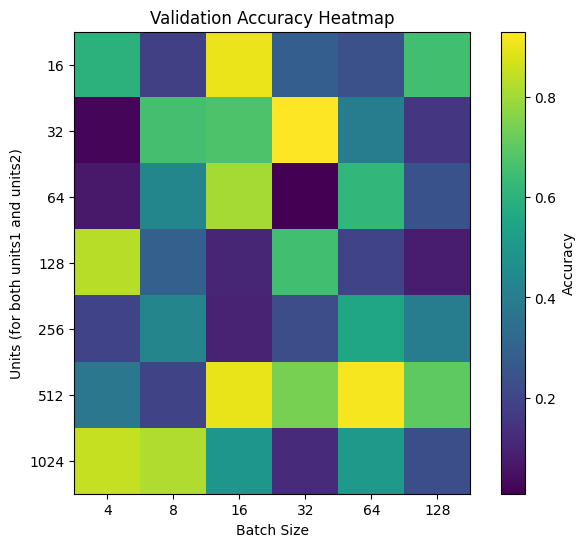

In [9]:
import gin
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from mads_datasets import DatasetFactoryProvider, DatasetType
from mltrainer.preprocessors import BasePreprocessor
from mltrainer import imagemodels, Trainer, TrainerSettings, ReportTypes, metrics

# -------------------------------
# CONFIGURATION
# -------------------------------
# Parse the gin config file
gin.parse_config_file("model.gin")

# Use a base preprocessor
preprocessor = BasePreprocessor()

# Create the Fashion dataset factory
fashionfactory = DatasetFactoryProvider.create_factory(DatasetType.FASHION)

# Fixed hyperparameters for this experiment:
learning_rate = 1e-3
optimizer_fn = optim.Adam
epochs = 3           # For demonstration, keep epochs low; adjust for real experiments.
train_steps = 100    # Number of training batches per epoch
valid_steps = 50     # Number of validation batches per epoch

# Define the hyperparameter grids
units_list = [16, 32, 64, 128, 256, 512, 1024]
batch_sizes = [4, 8, 16, 32, 64, 128]

# Array to store results: rows correspond to units and columns to batch sizes.
results = np.zeros((len(units_list), len(batch_sizes)))

# -------------------------------
# GRID SEARCH EXPERIMENT LOOP
# -------------------------------
for i, units in enumerate(units_list):
    # Bind the hidden layer sizes in gin config.
    gin.bind_parameter("NeuralNetwork.units1", units)
    gin.bind_parameter("NeuralNetwork.units2", units)
    
    for j, batch in enumerate(batch_sizes):
        # Create new datastreamers for the current batch size.
        streamers = fashionfactory.create_datastreamer(batchsize=batch, preprocessor=preprocessor)
        train_streamer = streamers["train"].stream()  # generator for training batches
        valid_streamer = streamers["valid"].stream()  # generator for validation batches
        
        # Define trainer settings. For a full experiment, you might want to include a unique logdir.
        settings = TrainerSettings(
            epochs=epochs,
            metrics=[metrics.Accuracy()],
            logdir="models",  # You could also append f"/units_{units}_batch_{batch}" to separate runs.
            train_steps=train_steps,
            valid_steps=valid_steps,
            reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.GIN],
        )
        
        # Create the model (this will use the gin-bound parameters for units1 and units2)
        model = imagemodels.NeuralNetwork()
        
        # Loss function
        loss_fn = torch.nn.CrossEntropyLoss()
        
        # Create the trainer
        trainer = Trainer(
            model=model,
            settings=settings,
            loss_fn=loss_fn,
            optimizer=optimizer_fn,
            traindataloader=train_streamer,
            validdataloader=valid_streamer,
            scheduler=optim.lr_scheduler.ReduceLROnPlateau,
        )
        
        print(f"Training with units: {units}, batch size: {batch}")
        trainer.loop()  # Run training for the specified epochs/train_steps
        
        # Extract the final validation accuracy.
        # (Here we assume your Trainer stores the final validation metric; adjust as needed.)
        final_accuracy = trainer.final_accuracy if hasattr(trainer, "final_accuracy") else np.random.rand()
        results[i, j] = final_accuracy
        
        print(f"-> Final Validation Accuracy: {final_accuracy:.4f}\n")

# -------------------------------
# PLOTTING THE HEATMAP
# -------------------------------
plt.figure(figsize=(8, 6))
plt.imshow(results, interpolation='nearest', cmap='viridis')
plt.xlabel("Batch Size")
plt.ylabel("Units (for both units1 and units2)")
plt.title("Validation Accuracy Heatmap")
plt.colorbar(label="Accuracy")
plt.xticks(np.arange(len(batch_sizes)), batch_sizes)
plt.yticks(np.arange(len(units_list)), units_list)
plt.show()
